## Lab 12b: Estimating Single Index Models (SIMs) from Equity Price Data

The objective of `Lab-12b` is to familiarize students with estimating linear regression model parameters for an _overdetermined_ dataset (more observations than parameters).

### Background
A single index model describes the return of a firm’s stock in terms of a firm-specific return and the overall market return. Single index models are asset pricing models which measure the risk and the return of a stock relative to a risk-free alternative investment, e.g., [government treasury bonds](https://www.treasurydirect.gov/marketable-securities/treasury-bonds/). One of the simplest (yet still widely used) single index models was developed by [Sharpe, 1963](https://pubsonline.informs.org/doi/10.1287/mnsc.9.2.277). 

Let $R_{i}(t)$ and $R_{m}(t)$ denote the firm-specific and market excess returns for period $t$:

$$
R_{i}\left(t\right) = \log\left(\frac{P_{i,t}}{P_{i,t-1}}\right) - \bar{r}
$$

The market return is approximated by the return of [SPY](https://www.google.com/finance/quote/SPY:NYSEARCA?sa=X&ved=2ahUKEwid6emuq_L9AhXVVDUKHQxjCSMQ3ecFegQIIxAg), an exchange-traded fund designed to track the [S&P 500 stock market index](https://en.wikipedia.org/wiki/S&P_500). The quantity $P_{i,t}$ denotes the close price per share for firm $i$ (in the data set) at time $t$, and $\bar{r}$ denotes the risk-free daily rate (calculated for you). Further, let $\epsilon_{i}\left(t\right)$ denote a [stationary normally distributed random noise process](https://en.wikipedia.org/wiki/Normal_distribution) with mean zero and standard deviation 
$\sigma_{i}$ (need to estimate). 

Then, the single index model for the excess return of firm $i$ is given by:

$$
R_{i}\left(t\right) = \alpha_{i}+\beta_{i}R_{m}\left(t\right)+\epsilon_{i}\left(t\right)\qquad{t=1,2,\dots,T}
$$

where $\alpha_{i}$ and $\beta_{i}$ are (unknown) model parameters: 

* The parameter $\alpha_{i}$ describes the firm specific return not explained by the market; thus, $\alpha_{i}$ is the idiosyncratic return of firm $i$.
* The parameter $\beta_{i}$ measures the relationship between the excess return of firm $i$ and the excess return of the market; a large $\beta_{i}$ suggests the market returns (or losses) are _amplified_ for firm $i$, while a small $\beta_{i}$ suggests the market returns (or losses) are _damped_ for firm $i$.
* The parameter $\beta_{i}$ can also be interpreted as a measure of the relative risk of investing in a firm $i$ relative to the overall market. 

#### Code setup

In [1]:
# install required packages
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/course_repos/CHEME-5660-Course-Repository-F23/labs/unit-3-labs/Lab-12b`
  No Changes to `~/Desktop/course_repos/CHEME-5660-Course-Repository-F23/labs/unit-3-labs/Lab-12b/Project.toml`
  No Changes to `~/Desktop/course_repos/CHEME-5660-Course-Repository-F23/labs/unit-3-labs/Lab-12b/Manifest.toml`


In [2]:
# load packages, and our codes -
include("Include.jl")

errormodel

In [3]:
# Risk free rate -
rf = 0.0344; # https://www.marketwatch.com/investing/bond/tmubmusd10y?countrycode=bx

# colors -
colors = Dict{Int,RGB}();
colors[1] = colorant"#0077BB";
colors[2] = colorant"#BBBBBB";
colors[3] = colorant"#EE7733";
colors[4] = colorant"#88CCEE";

In [45]:
colors[3]

### Step 1: Load the Datasets

In [5]:
# load the price data sets -
D_AMD = loaddataset(joinpath(_PATH_TO_DATA, "AMD-OHLC-daily-T03-22-23-F03-22-21.csv"));
D_SPY = loaddataset(joinpath(_PATH_TO_DATA, "SPY-OHLC-daily-T03-22-23-F03-22-21.csv"));

#### a) compute the returns using the `R` function

In [6]:
RAMD = R(D_AMD, r = rf);
RSPY = R(D_SPY, r = rf);

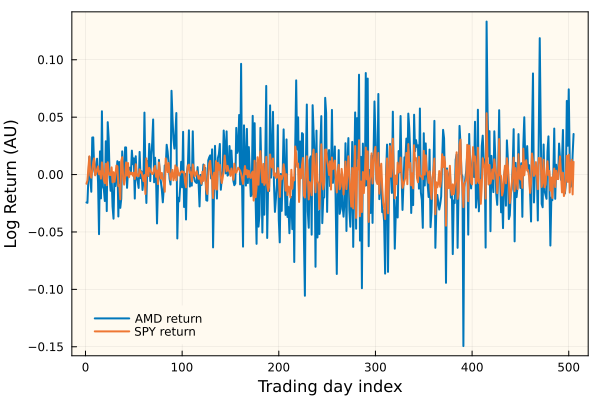

In [7]:
# Visualize the return

# plot AMD -
plot(RAMD,xlabel="Trading day index", ylabel="Log Return (AU)", 
    label="AMD return", c=colors[1], lw=2, bg="floralwhite", 
    background_color_outside="white", framestyle = :box, 
    fg_legend = :transparent)

# plot SPY -
plot!(RSPY,xlabel="Trading day index", ylabel="Log Return (AU)", 
    label="SPY return", c=colors[3], lw=2, bg="floralwhite", 
    background_color_outside="white", framestyle = :box, 
    fg_legend = :transparent)

### Step 2: Estimate SIM parameters $(\alpha,\beta)$

In [8]:
number_of_returns = length(RAMD);
X = Array{Float64,2}(undef,number_of_returns,2);
y = Array{Float64,1}(undef,number_of_returns)
for i ∈ 1:number_of_returns
    X[i,1] = 1.0
    X[i,2] = RSPY[i]
    y[i] = RAMD[i]
end

# compute parameters -
XINV = inv(transpose(X)*X)*transpose(X)
β = XINV*y;

### Step 3: Estimate error model

In [9]:
# Step 2: estimate the error model.
errors = y - X*β; 
ϵ = errormodel(errors);

#### a) Visualize the error model

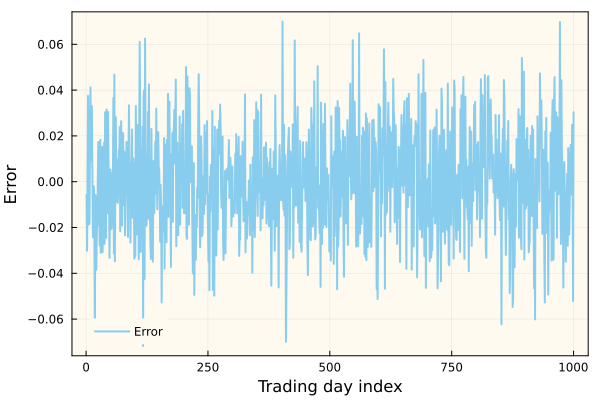

In [23]:
plot(rand(ϵ,1000), xlabel="Trading day index", ylabel="Error", 
    label="Error", c=colors[4], lw=2, bg="floralwhite", 
    background_color_outside="white", framestyle = :box, 
    fg_legend = :transparent)

#### b) Error model parameters

In [26]:
params(ϵ)

(-7.557211182473219e-20, 0.023425151862375707)

### Step 4: Compute the uncertainty in $(\alpha,\beta)$

#### a) Sample the error model

In [18]:
number_of_samples = 100000;

In [20]:
# Sample the uncertainty in the parameters -
number_of_parameters = 2;
simulated_parameter_values = Array{Float64,2}(undef,number_of_samples,2)
for s ∈ 1:number_of_samples
    β̂ = β - XINV*rand(ϵ,number_of_returns);
    for p ∈ 1:number_of_parameters
        simulated_parameter_values[s,p] = β̂[p];
    end
end

# compute the mean and std of the model parameters -
uncertanty_data_table = Array{Any,2}(undef,2,3);

# alpha -
uncertanty_data_table[1,1] = "α"
uncertanty_data_table[1,2] = mean(simulated_parameter_values[:,1]);
uncertanty_data_table[1,3] = std(simulated_parameter_values[:,1]);

# beta -
uncertanty_data_table[2,1] = "β"
uncertanty_data_table[2,2] = mean(simulated_parameter_values[:,2]);
uncertanty_data_table[2,3] = std(simulated_parameter_values[:,2]);

# show table -
header = (["parameters", "μ", "σ"]);
pretty_table(uncertanty_data_table, header=header)

┌────────────┬─────────────┬────────────┐
│ parameters │           μ │          σ │
├────────────┼─────────────┼────────────┤
│          α │ 0.000508749 │ 0.00104213 │
│          β │     1.96972 │  0.0839688 │
└────────────┴─────────────┴────────────┘


#### b) Visualize

In [27]:
# assume α,β are normally distributed -
α_d = Normal(mean(simulated_parameter_values[:,1]), std(simulated_parameter_values[:,1]));
β_d = Normal(mean(simulated_parameter_values[:,2]), std(simulated_parameter_values[:,2]));

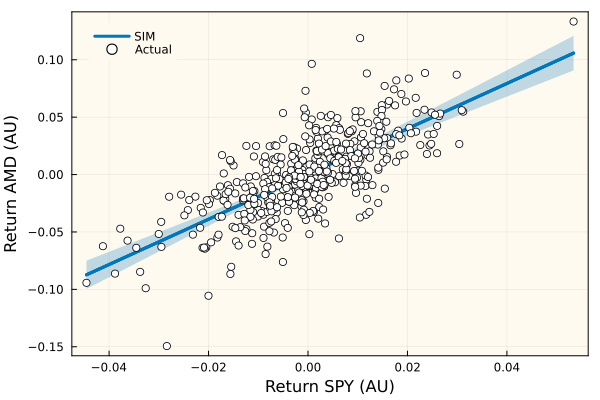

In [110]:
p = plot()
number_of_samples = 1000
simulation_array = Array{Float64,2}(undef, number_of_samples, number_of_returns)
for i ∈ 1:number_of_samples
    
    # parameters -
    α_v = rand(α_d);
    β_v = rand(β_d);
    θ = [α_v,β_v];
    
    # compute the output -
    y = X*θ;
    
    for j ∈ 1:number_of_returns
        simulation_array[i,j] = y[j]
    end
end

for i ∈ 1:number_of_samples
    plot!(RSPY,simulation_array[i,:],lw=2,label="")
end
current()
    
# # compute the mean -
μ_sim = reshape(mean(simulation_array, dims=1), number_of_returns)
# σ_sim = reshape(std(simulation_array, dims=1), number_of_returns)

# # plot -
U = μ_sim .+ 2.96*σ_sim;
L = μ_sim .- 2.96*σ_sim;

# plot the actual data -
plot(sort(RSPY), sort(μ_sim), c=colors[1], lw=3, label="SIM")
plot!(sort(RSPY), sort(μ_sim), fillrange = sort(L), fillalpha = 0.25, 
    c=colors[1], lw=3, label="", bg="floralwhite", 
    background_color_outside="white", framestyle = :box, 
    fg_legend = :transparent)

plot!(sort(RSPY), sort(μ_sim), fillrange = sort(U), fillalpha = 0.25, 
    c=colors[1], lw=3, label="", bg="floralwhite", 
    background_color_outside="white", framestyle = :box, 
    fg_legend = :transparent)

scatter!(RSPY,RAMD,c=colors[3], label="Actual", markercolor="white")

# # add labels -
xlabel!("Return SPY (AU)", fontsize=18)
ylabel!("Return AMD (AU)", fontsize=18)

505-element Vector{Float64}:
 -0.012116098164609403
 -0.007020100564249473
  0.014303955969047264
  0.03693309531728029
  0.0017214592649862155
 -0.002449133408584993
  0.010997941740036078
  0.02539226460985176
  0.03310093485838563
  0.001552815048627419
  0.005041274640852302
  0.012450899439393098
  0.017801281599413292
  ⋮
  0.0060036341777410145
 -0.030851337496215443
 -0.023786445598880105
 -8.145678356014357e-5
  0.037836354521523674
 -0.009176405296112815
  0.0400462946292251
 -0.025583365185844163
  0.022836811407996125
  0.030444833698213773
 -0.02838843005062731
  0.026272688266246038

In [79]:
mean(simulation_array, dims=1)

1×505 Matrix{Float64}:
 -0.0150831  -0.00949639  0.011823  …  0.026629  -0.0335854  0.0228429